# Youtube Video Preprocessing

In [1]:
#Importing Youtube module|
from pytube import YouTube 

In [2]:
#Downloading a Youtube Video
link="https://youtu.be/LjhCEhWiKXk"
yt = YouTube(link)
filename=link.split("/")[-1]+".mp4"  #Giving a filename

#Choosing a 360p MP4 video
mp4_files = yt.streams.filter(file_extension="mp4").get_by_resolution("360p")
mp4_files.download(filename=filename)

'/home/shivam/Documents/Hackfest/Seekr/Models/LjhCEhWiKXk.mp4'

# Extracting Frames

In [3]:
#Importing CV2
import cv2
from PIL import Image

In [4]:
#Capturing Frames into an Array
cap = cv2.VideoCapture(filename)
video_frames=[]
N=60 #Skip Frames
frame_num=0
fps=cap.get(cv2.CAP_PROP_FPS)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    video_frames.append(Image.fromarray(frame[:, :, ::-1]))
    frame_num += N
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num) #Skipping Frames
cap.release()

In [5]:
#Number of Frames Captured
len(video_frames)

95

# Feature Extraction

In [6]:
#Imports for Using CLIP
import torch
import clip
from PIL import Image
import math
import numpy 

#Model Import
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [7]:
#Preprocessor we get for applying various transformers on Image
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fd9058f70a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [8]:
#Setting Batch Size and splitting in batches
batch_size = 256
batches = math.ceil(len(video_frames) / batch_size)

In [9]:
#To Store Encoded Frames
video_features = torch.empty([0, 512], dtype=torch.float16).to(device) 

#Frames Processing
for i in range(batches):
    print(f"Processing batch {i+1}/{batches}")
    batch_frames = video_frames[i*batch_size : (i+1)*batch_size] #Getting the i'th Batch
    #Preprocessing batch
    batch_preprocessed = torch.stack([preprocess(frame) for frame in batch_frames]).to(device)
    with torch.no_grad():
        batch_features = model.encode_image(batch_preprocessed)  #Encoding 
        batch_features /= batch_features.norm(dim=-1, keepdim=True)
    video_features = torch.cat((video_features, batch_features)) #Adding to video_features
# Print some stats
print(f"Features Shape: {video_features.shape}")

Processing batch 1/1
Features Shape: torch.Size([95, 512])


In [10]:
# Encode and normalize the search query using CLIP
with torch.no_grad():
    text_features = model.encode_text(clip.tokenize("man playing piano").to(device))
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [11]:
# Compute the similarity between the search query and each frame using the Cosine similarity
similarities = (100.0 * video_features @ text_features.T)
values, best_photo_idx = similarities.topk(3, dim=0)

In [12]:
type(similarities)

torch.Tensor

In [13]:
#Indexes of best matches
best_photo_idx

tensor([[88],
        [70],
        [78]])

In [14]:
similarities[:10]

tensor([[23.4520],
        [16.6577],
        [24.8502],
        [20.0599],
        [16.7459],
        [18.7156],
        [23.2777],
        [22.4307],
        [21.0745],
        [20.0253]])

Search query heatmap over the frames of the video:


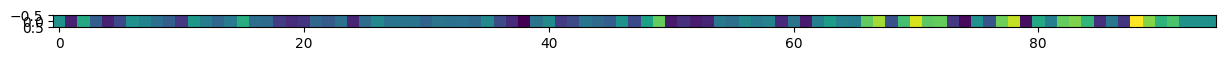

In [15]:
#Heatmap of Video Search
import matplotlib.pyplot as plt
print("Search query heatmap over the frames of the video:")
plt.figure(figsize=(15,0.5))
plt.imshow(similarities.T.cpu().numpy())

plt.show()

In [16]:
import datetime
#Function to search and give timestamp
def search_video(search_query):
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize(search_query).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    similarities = (100.0 * video_features @ text_features.T)
    values, best_photo_idx = similarities.topk(3, dim=0)
    
    # Display the top 3 frames
    for frame_id in best_photo_idx:
        display(video_frames[frame_id])
        # Find the timestamp in the video and display it
        seconds = round(frame_id.cpu().numpy()[0] * N / fps)
        print(str(datetime.timedelta(seconds=seconds)))

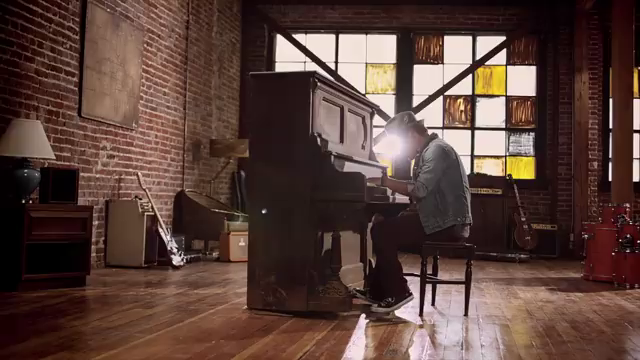

0:03:40


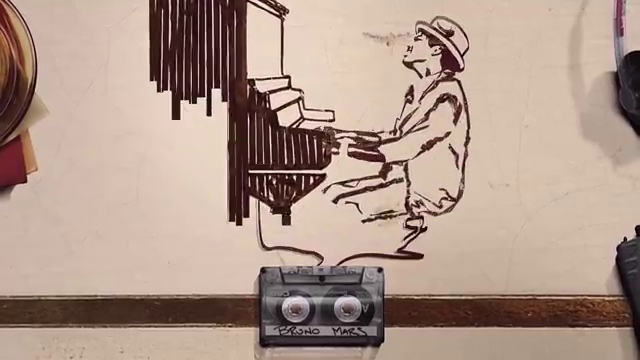

0:02:55


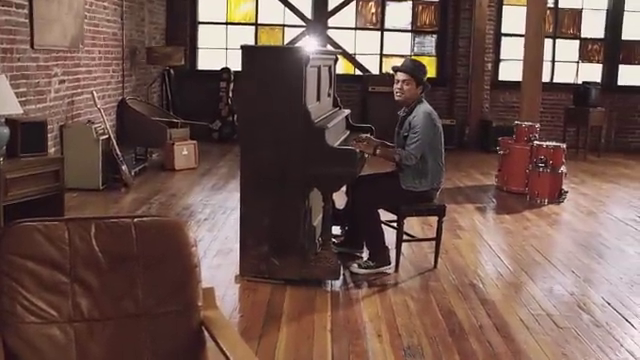

0:03:15


In [17]:
search_video("man playing piano")

# Making functions

In [18]:
#Imports
from pytube import YouTube 
import cv2
import torch
import clip
from PIL import Image
import math
import numpy 
import datetime
from IPython.core.display import HTML
import yt_dlp as youtube_dl

In [19]:
def video_download(link):
    print("Video Downloading")
    #Downloading a Youtube Video
    yt = YouTube(link)
    filename=link.split("/")[-1]+".mp4"  #Giving a filename
    #Choosing a 360p MP4 video
    mp4_files = yt.streams.filter(file_extension="mp4")
    mp4_files = mp4_files.get_by_resolution("360p")
    mp4_files.download(filename=filename)
    return filename
def video_frames_capture(filename):
    print("Frames Capturing...")
    #Capturing Frames into an Array
    cap = cv2.VideoCapture(filename)
    video_frames=[]
    N=60 #Skip Frames
    frame_num=0
    fps=cap.get(cv2.CAP_PROP_FPS)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        video_frames.append(Image.fromarray(frame[:, :, ::-1]))
        frame_num += N
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num) #Skipping Frames
    cap.release()
    return video_frames
def frame_classifier(video_frames):
    #Setting Batch Size and splitting in batches
    batch_size = 256
    batches = math.ceil(len(video_frames) / batch_size)
    #To Store Encoded Frames
    video_features = torch.empty([0, 512], dtype=torch.float16).to(device) 

    #Frames Processing
    for i in range(batches):
        print(f"Processing batch {i+1}/{batches}")
        batch_frames = video_frames[i*batch_size : (i+1)*batch_size] #Getting the i'th Batch
        #Preprocessing batch
        batch_preprocessed = torch.stack([preprocess(frame) for frame in batch_frames]).to(device)
        with torch.no_grad():
            batch_features = model.encode_image(batch_preprocessed)  #Encoding 
            batch_features /= batch_features.norm(dim=-1, keepdim=True)
        video_features = torch.cat((video_features, batch_features)) #Adding to video_features
        # Print some stats
        print(f"Features Shape: {video_features.shape}")
    return video_features
import datetime
#Function to search and give timestamp
def search_video_link(search_query,link):
    video=video_download(link)
    video_frames_captured=video_frames_capture(video)
    video_frames=frame_classifier(video_frames_captured)
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize(search_query).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    similarities = (100.0 * video_features @ text_features.T)
    values, best_photo_idx = similarities.topk(3, dim=0)
    # Display the top 3 frames
    for frame_id in best_photo_idx:
        display(video_frames_captured[frame_id])
        # Find the timestamp in the video and display it
        seconds = round(frame_id.cpu().numpy()[0] * N / fps)
        print(str(datetime.timedelta(seconds=seconds)))
        display(HTML(f"Found at {str(datetime.timedelta(seconds=seconds))} (<a target=\"_blank\" href=\"{link}&t={seconds}\">link</a>)"))

Video Downloading
Frames Capturing...
Processing batch 1/1
Features Shape: torch.Size([95, 512])


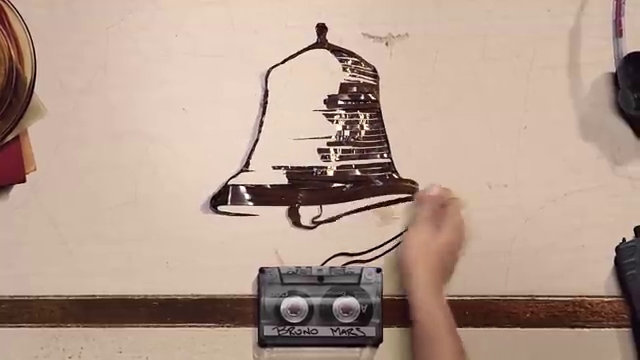

0:02:43


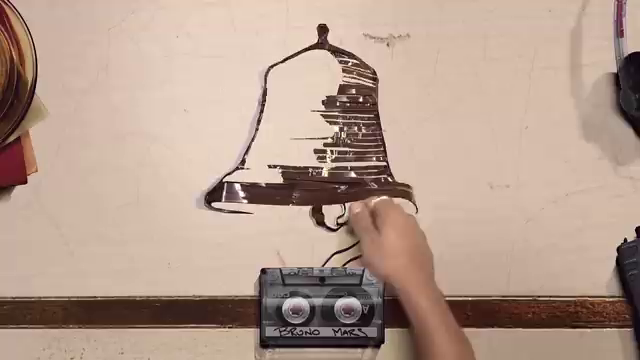

0:02:40


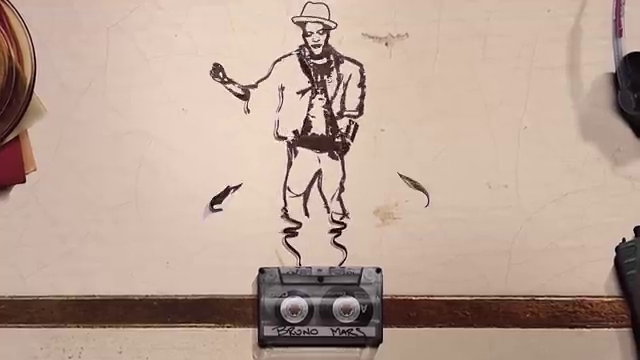

0:02:38


In [20]:
search_video_link("Man ringins bell","https://youtu.be/LjhCEhWiKXk")

Video Downloading
Frames Capturing...
Processing batch 1/1
Features Shape: torch.Size([95, 512])


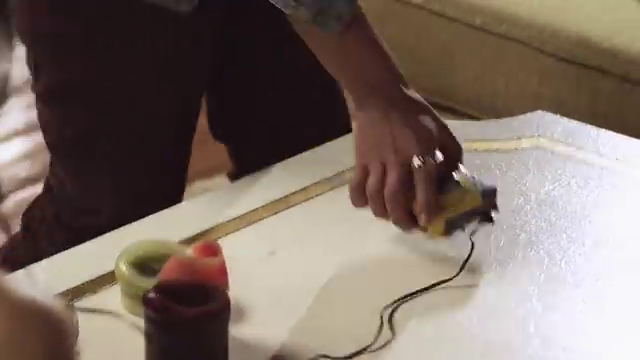

0:00:05


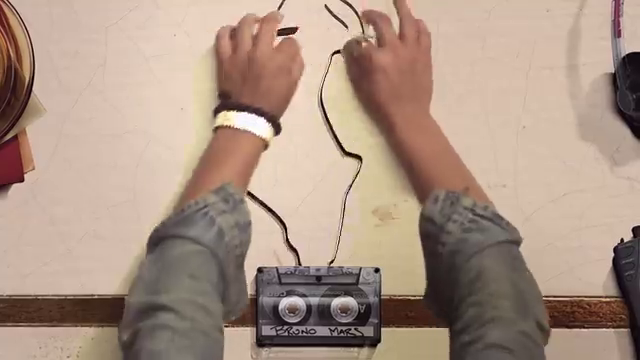

0:01:05


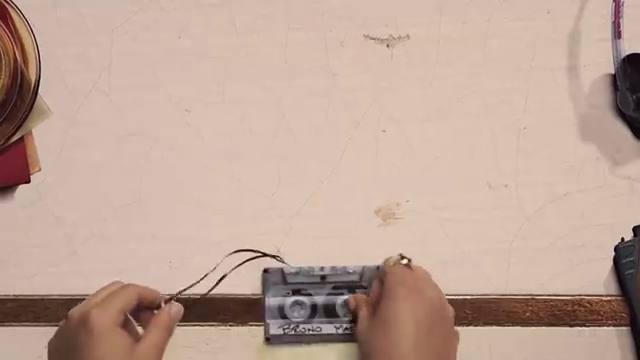

0:00:15


In [21]:
search_video_link("Cassettle Tape","https://youtu.be/LjhCEhWiKXk")

Video Downloading
Frames Capturing...


[h264 @ 0x55aa35e20380] mmco: unref short failure
[h264 @ 0x55aa35e20380] mmco: unref short failure


Processing batch 1/2
Features Shape: torch.Size([256, 512])
Processing batch 2/2
Features Shape: torch.Size([304, 512])


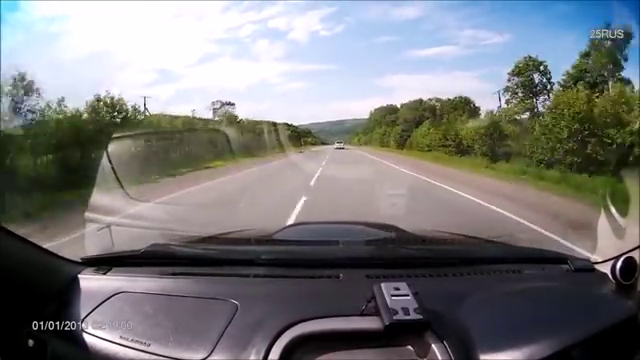

0:00:05


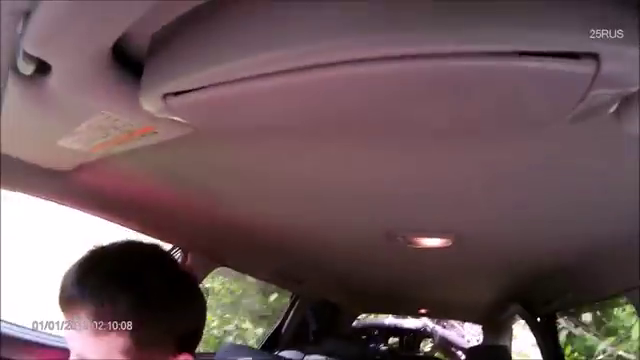

0:00:15


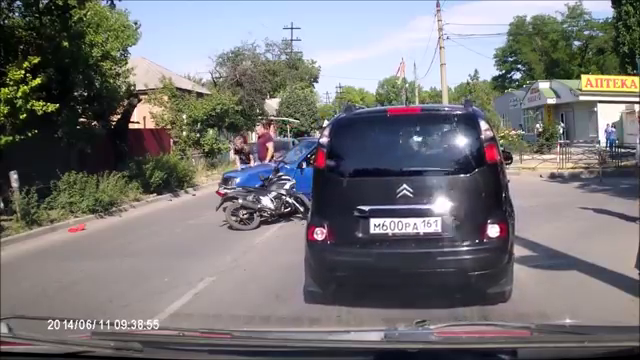

0:03:55


In [22]:
search_video_link("Car Crash","https://www.youtube.com/watch?v=kVl-6-A9ZO4&authuser=0")